In [1]:
from PIL import Image
import json
import requests
import numpy as np
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2_grpc
import grpc
import tensorflow as tf 
import matplotlib.pyplot as plt
%matplotlib inline 

# docker run -t  -p 8500:8500 -p 8501:8501 -v $(pwd)/servable/arbitary_style/:/models/model -e MODEL_NAME=model tensorflow/serving:latest
# https://www.tensorflow.org/tfx/serving/api_rest
# https://stackoverflow.com/questions/44657621/tensorflow-tensorflow-serving-multiple-inputs-for-savedmodel-signature 
# curl http://localhost:8501/v1/models/model
# tensorflow_model_server --port=8500 --rest_api_port=8501 --model_name=model --model_base_path=/models/model


In [34]:
# check model info 
!saved_model_cli show --dir "servable/arbitary_style/1/" --all



MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['predict_images']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['content_img'] tensor_info:
        dtype: DT_FLOAT
        shape: (1, -1, -1, 3)
        name: content:0
    inputs['style_img'] tensor_info:
        dtype: DT_FLOAT
        shape: (1, -1, -1, 3)
        name: style:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output_img'] tensor_info:
        dtype: DT_FLOAT
        shape: (1, -1, -1, 3)
        name: clip_by_value:0
  Method name is: tensorflow/serving/predict


input content image original size (3578, 2397)
input style image original size (591, 800)
input content image resized size (1, 468, 700, 3)
input style image resized size (1, 700, 517, 3)
input image dtype float32


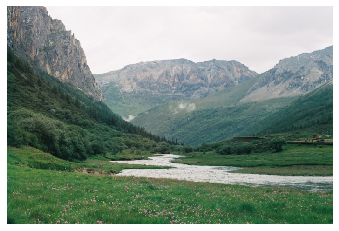

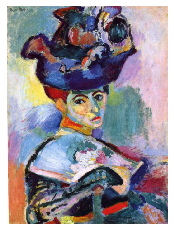

In [70]:
# Load Image

content_img = Image.open('./test_content_img1.jpg')
style_img = Image.open('./test_style_img3.jpg')

print('input content image original size', content_img.size)
print('input style image original size', style_img.size)

def img_resize(img):
    h, w = img.size
    IMG_LONG_SIZE = 700.

    if h > w : # h is the long side 
        h_new = int(IMG_LONG_SIZE)
        w_new = int(IMG_LONG_SIZE * (w * (1.0) ) / ( h  * (1.0) ) )
    else:      # w is the long side 
        w_new = int(IMG_LONG_SIZE)
        h_new = int(IMG_LONG_SIZE * (h * (1.0) ) / ( w  * (1.0) ) )
    img = img.resize((h_new, w_new), resample=Image.BILINEAR)
    return img 

content_img = img_resize(content_img)
style_img = img_resize(style_img)

content_img_np = np.array(content_img).astype(np.float32)
content_img_np = np.expand_dims(content_img_np, axis=0)  

style_img_np = np.array(style_img).astype(np.float32)
style_img_np = np.expand_dims(style_img_np, axis=0)

print('input content image resized size', content_img_np.shape)
print('input style image resized size', style_img_np.shape)
print('input image dtype', style_img_np.dtype)

plt.figure()
plt.imshow(content_img_np[0].astype(np.uint8))
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(style_img_np[0].astype(np.uint8))
plt.axis('off')
plt.show()


In [71]:
#gRPC
channel = grpc.insecure_channel("0.0.0.0:8500")
stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
request = predict_pb2.PredictRequest()
request.model_spec.name = "model"
request.model_spec.signature_name = "predict_images" 
request.inputs["content_img"].CopyFrom(  
        tf.make_tensor_proto(content_img_np, shape=list(content_img_np.shape)))  
request.inputs["style_img"].CopyFrom(  
        tf.make_tensor_proto(style_img_np, shape=list(style_img_np.shape)))  
response = stub.Predict(request, 20.0) 
output_img = tf.make_ndarray(response.outputs['output_img'])


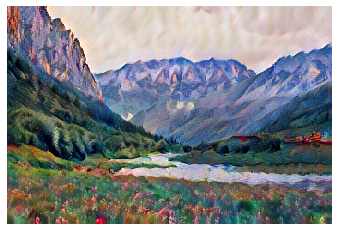

In [73]:
plt.figure()
plt.imshow(output_img[0].astype(np.uint8))
plt.axis('off')
plt.show()